In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import scipy
from skimage import color
import tempfile
import os
from timeit import default_timer as timer
from tempfile import TemporaryFile
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import WhiteKernel
from sklearn.gaussian_process.kernels import ExpSineSquared
import decimal
from decimal import *
from sklearn.gaussian_process.kernels import ConstantKernel
from numpy import loadtxt
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import keras
from sklearn.metrics import roc_auc_score
import pickle


In [56]:
import h5py
import matplotlib as mpl

In [57]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [3]:
def Confus_analyzer(class_array, pred_array):
    
    TN, FP, FN, TP = confusion_matrix(class_array, val_pred).ravel()
    
    Accuracy = ((TP+TN)/(TP+TN+FP+FN))
    print('Accuracy: ' + str(Accuracy))
    #Sensitivity or Recall; rate of TP on all positives
    Recall = ((TP)/(TP+FN))
    print('Recall: ' + str(Recall))
    Misclass = ((FP+FN)/(TP+TN+FP+FN))
    print('Misclassifications: ' + str(Misclass))
    #Percentage of correct TP predictions
    Precision = ((TP)/(TP+FP))
    print('Precision: ' + str(Precision))
    #F1 score
    F1_score = 2*((Precision*Recall)/(Precision+Recall))
    print('F1_Score' + str(F1_score))
    ROC_AUC = roc_auc_score(class_array, pred_array)
    print('ROC_AUC: ' + str(ROC_AUC))
    
    
    return()

In [4]:
def Dataframe_processor(DF_path_1, DF_path_2, appendmode=False):
    
    if appendmode == True:
    
        DF_1 = pickle.load(open(DF_path_1, 'rb'))
        DF_2 = pickle.load(open(DF_path_2, 'rb'))


        DF_C = DF_1.append(DF_2)
        DF_C = DF_C.reset_index(drop=True)


        DF_C_signals = DF_C.iloc[:, 0:(DF_C.shape[1]-1)]
        DF_C_signals = DF_C_signals.to_numpy(copy=True)


        DF_C_classes = DF_C.iloc[:, (DF_C.shape[1]-1):DF_C.shape[1]]
        DF_C_classes = DF_C_classes.to_numpy(copy=True)
    
        return(DF_C_signals, DF_C_classes)
    
    if appendmode == False:
        
        DF_C = pickle.load(open(DF_path_1, 'rb'))
        
        DF_C_signals = DF_C.iloc[:, 0:(DF_C.shape[1]-1)]
        DF_C_signals = DF_C_signals.to_numpy(copy=True)


        DF_C_classes = DF_C.iloc[:, (DF_C.shape[1]-1):DF_C.shape[1]]
        DF_C_classes = DF_C_classes.to_numpy(copy=True)
    
        return(DF_C_signals, DF_C_classes)
    

In [5]:
#pickle_off = open("Emp.pickle","rb")
#emp = pickle.load(pickle_off)
#print(emp)

In [6]:
train_df_22 ='/bph/puredata1/bioinfdata/user/phikie/Big_data_set_creation/Split_dfs/P22/P22_train.pkl'
train_df_109C ='/bph/puredata1/bioinfdata/user/phikie/Big_data_set_creation/Split_dfs/P109C/P109_train.pkl'
val_df_22 = '/bph/puredata1/bioinfdata/user/phikie/Big_data_set_creation/Split_dfs/P22/P22_val.pkl'
val_df_109 = '/bph/puredata1/bioinfdata/user/phikie/Big_data_set_creation/Split_dfs/P109C/P109_val.pkl'
test_df_22 = '/bph/puredata1/bioinfdata/user/phikie/Big_data_set_creation/Split_dfs/P22/P22_test.pkl'
test_df_109 = '/bph/puredata1/bioinfdata/user/phikie/Big_data_set_creation/Split_dfs/P109C/P109_test.pkl'

In [7]:
#tr_sig_109, tr_cl_109 = Dataframe_processor(train_df_109C, None, appendmode=False)

In [8]:
#tr_sig_109 = np.nan_to_num(tr_sig_109)

In [9]:
#tr_sig_22, tr_cl_22 = Dataframe_processor(train_df_22, None, appendmode=False)

In [10]:
train_signals, train_classes = Dataframe_processor(train_df_22, train_df_109C, appendmode=True)

In [11]:
val_signals, val_classes = Dataframe_processor(val_df_22, val_df_109, appendmode=True)

In [12]:
test_signals, test_classes = Dataframe_processor(test_df_22, test_df_109, appendmode=True)

In [13]:
train_signals = np.nan_to_num(train_signals)
val_signals = np.nan_to_num(val_signals)
test_signals = np.nan_to_num(test_signals)


In [14]:
uniques, occurrences = np.unique(train_classes, return_counts=True)
ratio = occurrences[1]/(occurrences[0]+occurrences[1])

In [15]:
class_weight_1 = 1/ratio

In [16]:
class_weight_1

37.79888264796193

In [17]:
Metrics = [
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.FalseNegatives(name='fn'),
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='AUC'),
    keras.metrics.AUC(name='prc', curve='PR'),
]



In [18]:
def Modelbuilder(train_signals,
                 metrics=Metrics,
                 learning_rate=1e-4):

    
    model = keras.Sequential([
        keras.layers.Dense(
            512, activation='relu',
            input_shape=(train_signals.shape[1],)),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')])
    model.compile(
        optimizer = keras.optimizers.Adam(learning_rate=1e-4),
        loss = keras.losses.BinaryCrossentropy(),
        metrics=metrics)
    
    return(model)

In [19]:
def Modelbuilder_ada(train_signals,
                 metrics=Metrics,
                 learning_rate=1e-4):

    
    model = keras.Sequential([
        keras.layers.Dense(
            512, activation='relu',
            input_shape=(train_signals.shape[1],)),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')])
    model.compile(
        optimizer = keras.optimizers.Adagrad(learning_rate=1e-4),
        loss = keras.losses.BinaryCrossentropy(),
        metrics=metrics)
    
    return(model)

In [20]:
model1 = Modelbuilder(train_signals, metrics=Metrics, learning_rate=1e-4)
model2 = Modelbuilder(train_signals, metrics=Metrics, learning_rate=1e-4)
model3 = Modelbuilder(train_signals, metrics=Metrics, learning_rate=1e-5)
model4 = Modelbuilder(train_signals, metrics=Metrics, learning_rate=1e-6)
model5 = Modelbuilder(train_signals, metrics=Metrics, learning_rate=1e-4)
model6 = Modelbuilder(train_signals, metrics=Metrics, learning_rate=1e-4)
model7 = Modelbuilder_ada(train_signals, metrics=Metrics, learning_rate=1e-4)
model8 = Modelbuilder_ada(train_signals, metrics=Metrics, learning_rate=1e-4)
model9 = Modelbuilder_ada(train_signals, metrics=Metrics, learning_rate=1e-4)
model10 = Modelbuilder_ada(train_signals, metrics=Metrics, learning_rate=1e-4)


In [21]:
#Standard reference
model1_history = model1.fit(
    train_signals,
    train_classes,
    epochs = 5,
    batch_size = 128,
    class_weight={0:1, 1:class_weight_1},
    validation_data=(val_signals, val_classes))

Epoch 1/5
294577/294577 [==============================] - 1788s 6ms/step - loss: 1.2137 - tp: 366955.9488 - tn: 11146399.8949 - fp: 7208036.2250 - fn: 131638.7107 - accuracy: 0.6115 - precision: 0.0477 - recall: 0.7219 - AUC: 0.7172 - prc: 0.0598 - val_loss: 0.6443 - val_tp: 225965.0000 - val_tn: 6134679.0000 - val_fp: 4353435.0000 - val_fn: 59050.0000 - val_accuracy: 0.5904 - val_precision: 0.0493 - val_recall: 0.7928 - val_AUC: 0.7495 - val_prc: 0.0694
Epoch 2/5
294577/294577 [==============================] - 1769s 6ms/step - loss: 1.1550 - tp: 384166.6849 - tn: 11335105.1634 - fp: 7019121.1112 - fn: 114655.4175 - accuracy: 0.6205 - precision: 0.0517 - recall: 0.7700 - AUC: 0.7527 - prc: 0.0703 - val_loss: 0.6397 - val_tp: 226046.0000 - val_tn: 6273992.0000 - val_fp: 4214122.0000 - val_fn: 58969.0000 - val_accuracy: 0.6034 - val_precision: 0.0509 - val_recall: 0.7931 - val_AUC: 0.7572 - val_prc: 0.0723
Epoch 3/5
294577/294577 [==============================] - 1764s 6ms/step - loss

In [22]:
#No class weights
model2_history = model2.fit(
    train_signals,
    train_classes,
    epochs = 5,
    batch_size = 128,
    validation_data=(val_signals, val_classes))

Epoch 1/5
294577/294577 [==============================] - 1784s 6ms/step - loss: 0.1159 - tp: 219122.5018 - tn: 25012566.1209 - fp: 3830026.6247 - fn: 564448.1469 - accuracy: 0.8295 - precision: 0.0541 - recall: 0.3305 - AUC: 0.6460 - prc: 0.0512 - val_loss: 0.1120 - val_tp: 0.0000e+00 - val_tn: 10488114.0000 - val_fp: 0.0000e+00 - val_fn: 285015.0000 - val_accuracy: 0.9735 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_AUC: 0.7462 - val_prc: 0.0694
Epoch 2/5
294577/294577 [==============================] - 1803s 6ms/step - loss: 0.1116 - tp: 2.7492 - tn: 18353996.7789 - fp: 4.6668 - fn: 499043.0084 - accuracy: 0.9735 - precision: 0.2801 - recall: 4.3042e-06 - AUC: 0.7488 - prc: 0.0702 - val_loss: 0.1110 - val_tp: 5.0000 - val_tn: 10488114.0000 - val_fp: 0.0000e+00 - val_fn: 285010.0000 - val_accuracy: 0.9735 - val_precision: 1.0000 - val_recall: 1.7543e-05 - val_AUC: 0.7559 - val_prc: 0.0728
Epoch 3/5
294577/294577 [==============================] - 1765s 6ms/step - loss:

In [23]:
#Learning rate 1e-5
model3_history = model3.fit(
    train_signals,
    train_classes,
    epochs = 5,
    batch_size = 128,
    class_weight={0:1, 1:class_weight_1},
    validation_data=(val_signals, val_classes))

Epoch 1/5
294577/294577 [==============================] - 1826s 6ms/step - loss: 1.2140 - tp: 366689.9034 - tn: 21630675.6412 - fp: 7211976.9137 - fn: 416909.9982 - accuracy: 0.7664 - precision: 0.0475 - recall: 0.4165 - AUC: 0.6420 - prc: 0.0496 - val_loss: 0.5876 - val_tp: 209929.0000 - val_tn: 6719972.0000 - val_fp: 3768142.0000 - val_fn: 75086.0000 - val_accuracy: 0.6433 - val_precision: 0.0528 - val_recall: 0.7366 - val_AUC: 0.7473 - val_prc: 0.0676
Epoch 2/5
294577/294577 [==============================] - 1783s 6ms/step - loss: 1.1528 - tp: 384055.1779 - tn: 11348744.7562 - fp: 7006010.0972 - fn: 114247.3797 - accuracy: 0.6217 - precision: 0.0518 - recall: 0.7704 - AUC: 0.7534 - prc: 0.0702 - val_loss: 0.6381 - val_tp: 228817.0000 - val_tn: 6159859.0000 - val_fp: 4328255.0000 - val_fn: 56198.0000 - val_accuracy: 0.5930 - val_precision: 0.0502 - val_recall: 0.8028 - val_AUC: 0.7558 - val_prc: 0.0702
Epoch 3/5
294577/294577 [==============================] - 1739s 6ms/step - loss

In [24]:
#Learning rate 1e-6
model4_history = model4.fit(
    train_signals,
    train_classes,
    epochs = 5,
    batch_size = 128,
    class_weight={0:1, 1:class_weight_1},
    validation_data=(val_signals, val_classes))

Epoch 1/5
294577/294577 [==============================] - 1834s 6ms/step - loss: 1.2127 - tp: 577895.0659 - tn: 18075566.6910 - fp: 10767390.4159 - fn: 205371.8732 - accuracy: 0.6331 - precision: 0.0513 - recall: 0.7352 - AUC: 0.7406 - prc: 0.0662 - val_loss: 0.5993 - val_tp: 217592.0000 - val_tn: 6493498.0000 - val_fp: 3994616.0000 - val_fn: 67423.0000 - val_accuracy: 0.6229 - val_precision: 0.0517 - val_recall: 0.7634 - val_AUC: 0.7506 - val_prc: 0.0701
Epoch 2/5
294577/294577 [==============================] - 1757s 6ms/step - loss: 1.1524 - tp: 383594.8242 - tn: 11374565.7142 - fp: 6979816.6593 - fn: 115071.6627 - accuracy: 0.6234 - precision: 0.0520 - recall: 0.7691 - AUC: 0.7540 - prc: 0.0706 - val_loss: 0.6151 - val_tp: 224020.0000 - val_tn: 6383921.0000 - val_fp: 4104193.0000 - val_fn: 60995.0000 - val_accuracy: 0.6134 - val_precision: 0.0518 - val_recall: 0.7860 - val_AUC: 0.7583 - val_prc: 0.0725
Epoch 3/5
294577/294577 [==============================] - 1760s 6ms/step - los

In [25]:
#Batch size 512
model5_history = model5.fit(
    train_signals,
    train_classes,
    epochs = 5,
    batch_size = 512,
    class_weight={0:1, 1:class_weight_1},
    validation_data=(val_signals, val_classes))

Epoch 1/5
73645/73645 [==============================] - 480s 6ms/step - loss: 1.2229 - tp: 576671.3839 - tn: 17987204.8623 - fp: 10855540.9564 - fn: 207257.7805 - accuracy: 0.6297 - precision: 0.0508 - recall: 0.7341 - AUC: 0.7379 - prc: 0.0659 - val_loss: 0.5950 - val_tp: 216472.0000 - val_tn: 6512351.0000 - val_fp: 3975763.0000 - val_fn: 68543.0000 - val_accuracy: 0.6246 - val_precision: 0.0516 - val_recall: 0.7595 - val_AUC: 0.7482 - val_prc: 0.0677
Epoch 2/5
73645/73645 [==============================] - 465s 6ms/step - loss: 1.1561 - tp: 385604.2356 - tn: 11272737.4080 - fp: 7081562.7715 - fn: 113698.9882 - accuracy: 0.6175 - precision: 0.0515 - recall: 0.7717 - AUC: 0.7517 - prc: 0.0695 - val_loss: 0.6341 - val_tp: 227118.0000 - val_tn: 6223715.0000 - val_fp: 4264399.0000 - val_fn: 57897.0000 - val_accuracy: 0.5988 - val_precision: 0.0506 - val_recall: 0.7969 - val_AUC: 0.7564 - val_prc: 0.0713
Epoch 3/5
73645/73645 [==============================] - 457s 6ms/step - loss: 1.1374

In [26]:
#Batch size 64
model6_history = model6.fit(
    train_signals,
    train_classes,
    epochs = 5,
    batch_size = 64,
    class_weight={0:1, 1:class_weight_1},
    validation_data=(val_signals, val_classes))

Epoch 1/5
589153/589153 [==============================] - 3648s 6ms/step - loss: 1.2120 - tp: 591872.5731 - tn: 17700413.9499 - fp: 11141860.9083 - fn: 191916.4730 - accuracy: 0.6189 - precision: 0.0507 - recall: 0.7557 - AUC: 0.7440 - prc: 0.0681 - val_loss: 0.5557 - val_tp: 204255.0000 - val_tn: 6915311.0000 - val_fp: 3572803.0000 - val_fn: 80760.0000 - val_accuracy: 0.6609 - val_precision: 0.0541 - val_recall: 0.7166 - val_AUC: 0.7478 - val_prc: 0.0693
Epoch 2/5
589153/589153 [==============================] - 3566s 6ms/step - loss: 1.1652 - tp: 381623.8447 - tn: 11276926.8575 - fp: 7077559.5933 - fn: 116894.6486 - accuracy: 0.6187 - precision: 0.0511 - recall: 0.7649 - AUC: 0.7483 - prc: 0.0687 - val_loss: 0.5936 - val_tp: 212760.0000 - val_tn: 6651278.0000 - val_fp: 3836836.0000 - val_fn: 72255.0000 - val_accuracy: 0.6371 - val_precision: 0.0525 - val_recall: 0.7465 - val_AUC: 0.7484 - val_prc: 0.0686
Epoch 3/5
589153/589153 [==============================] - 3633s 6ms/step - los

In [27]:
#Adagrad optimizer
model7_history = model7.fit(
    train_signals,
    train_classes,
    epochs = 5,
    batch_size = 128,
    class_weight={0:1, 1:class_weight_1},
    validation_data=(val_signals, val_classes))

Epoch 1/5
294577/294577 [==============================] - 1808s 6ms/step - loss: 1.3229 - tp: 527664.3469 - tn: 17824660.0597 - fp: 11017761.3154 - fn: 256034.1735 - accuracy: 0.6226 - precision: 0.0465 - recall: 0.6792 - AUC: 0.6947 - prc: 0.0566 - val_loss: 0.6665 - val_tp: 183051.0000 - val_tn: 6373511.0000 - val_fp: 4114603.0000 - val_fn: 101964.0000 - val_accuracy: 0.6086 - val_precision: 0.0426 - val_recall: 0.6423 - val_AUC: 0.6564 - val_prc: 0.0472
Epoch 2/5
294577/294577 [==============================] - 1772s 6ms/step - loss: 1.2966 - tp: 324511.2990 - tn: 11055197.1965 - fp: 7299206.2294 - fn: 174099.5314 - accuracy: 0.6038 - precision: 0.0426 - recall: 0.6503 - AUC: 0.6593 - prc: 0.0477 - val_loss: 0.6632 - val_tp: 184644.0000 - val_tn: 6386896.0000 - val_fp: 4101218.0000 - val_fn: 100371.0000 - val_accuracy: 0.6100 - val_precision: 0.0431 - val_recall: 0.6478 - val_AUC: 0.6620 - val_prc: 0.0484
Epoch 3/5
294577/294577 [==============================] - 1757s 6ms/step - l

In [28]:
#Adagrad optimizer, no class weights
model8_history = model8.fit(
    train_signals,
    train_classes,
    epochs = 5,
    batch_size = 128,
    validation_data=(val_signals, val_classes))

Epoch 1/5
294577/294577 [==============================] - 1819s 6ms/step - loss: 0.1768 - tp: 185301.0000 - tn: 24875606.7477 - fp: 3966382.9998 - fn: 598935.7790 - accuracy: 0.8227 - precision: 0.0446 - recall: 0.2792 - AUC: 0.5567 - prc: 0.0375 - val_loss: 0.1196 - val_tp: 0.0000e+00 - val_tn: 10488114.0000 - val_fp: 0.0000e+00 - val_fn: 285015.0000 - val_accuracy: 0.9735 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_AUC: 0.6363 - val_prc: 0.0446
Epoch 2/5
294577/294577 [==============================] - 1786s 6ms/step - loss: 0.1193 - tp: 0.0000e+00 - tn: 18354579.3175 - fp: 0.0000e+00 - fn: 498358.2423 - accuracy: 0.9736 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.6383 - prc: 0.0449 - val_loss: 0.1190 - val_tp: 0.0000e+00 - val_tn: 10488114.0000 - val_fp: 0.0000e+00 - val_fn: 285015.0000 - val_accuracy: 0.9735 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_AUC: 0.6458 - val_prc: 0.0460
Epoch 3/5
294577/294577 [==============================] - 17

In [31]:
np.save('/bph/puredata1/bioinfdata/user/phikie/Neural_network_results/model1_history.npy', model1_history.history)

In [32]:
np.save('/bph/puredata1/bioinfdata/user/phikie/Neural_network_results/model2_history.npy', model2_history.history)

In [33]:
np.save('/bph/puredata1/bioinfdata/user/phikie/Neural_network_results/model3_history.npy', model3_history.history)

In [34]:
np.save('/bph/puredata1/bioinfdata/user/phikie/Neural_network_results/model4_history.npy', model4_history.history)

In [35]:
np.save('/bph/puredata1/bioinfdata/user/phikie/Neural_network_results/model5_history.npy', model5_history.history)

In [36]:
np.save('/bph/puredata1/bioinfdata/user/phikie/Neural_network_results/model6_history.npy', model6_history.history)

In [37]:
np.save('/bph/puredata1/bioinfdata/user/phikie/Neural_network_results/model7_history.npy', model7_history.history)

In [38]:
np.save('/bph/puredata1/bioinfdata/user/phikie/Neural_network_results/model8_history.npy', model8_history.history)

In [ ]:
#Example code to load np.history
#history1=np.load('history1.npy',allow_pickle='TRUE').item()


In [ ]:
NN_model.save('/bph/puredata1/bioinfdata/user/phikie/Big_data_set_creation/Neural_networks/NN_1_B32_adam.h5')

In [43]:
def Modelsaver(NN_model, path_and_name):
    
    NN_model.save(path_and_name + '.h5')

In [52]:
Modelsaver(
    model1,
    '/bph/puredata1/bioinfdata/user/phikie/Neural_network_results/model1')

In [45]:
Modelsaver(
    model2,
    '/bph/puredata1/bioinfdata/user/phikie/Neural_network_results/model2')

In [46]:
Modelsaver(
    model3,
    '/bph/puredata1/bioinfdata/user/phikie/Neural_network_results/model3')

In [47]:
Modelsaver(
    model4,
    '/bph/puredata1/bioinfdata/user/phikie/Neural_network_results/model4')

In [48]:
Modelsaver(
    model5,
    '/bph/puredata1/bioinfdata/user/phikie/Neural_network_results/model5')

In [49]:
Modelsaver(
    model6,
    '/bph/puredata1/bioinfdata/user/phikie/Neural_network_results/model6')

In [50]:
Modelsaver(
    model7,
    '/bph/puredata1/bioinfdata/user/phikie/Neural_network_results/model7')

In [51]:
Modelsaver(
    model8,
    '/bph/puredata1/bioinfdata/user/phikie/Neural_network_results/model8')

In [87]:
def Loss_plotter(history, n):
    
    %matplotlib inline
    
    plt.semilogy(history.epoch, history.history['loss'],
                 color=colors[n], label='Train')
    plt.semilogy(history.epoch, history.history['val_loss'],
                color=colors[n+1], label='Val')
    
    plt.legend(loc="upper left")
    
    plt.xlabel('Epoch')
    plt.ylabel('loss')

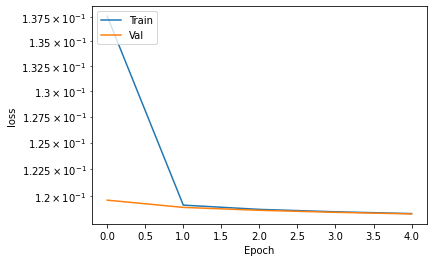

In [88]:
Loss_plotter(model8_history, 0)

In [91]:
model8_history.history['AUC'][4]

0.6552527546882629

In [123]:
#Takes in a keras history and returns a datafram with the most interesting metrics of the last epoch

def Tabler(hist):
    
    table = pd.DataFrame.from_dict(hist.history)
    table2 = table.iloc[(table.shape[0]-1):table.shape[0]]
    table3 = table2[['loss', 'accuracy', 'precision', 'recall', 'AUC', 'prc', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_AUC', 'val_prc']]
    table3 = table3.reset_index(drop=True)
    return(table3)
    

In [124]:
tabler_test = Tabler(model1_history)

In [125]:
tabler_test

,loss,accuracy,precision,recall,AUC,prc,val_loss,val_accuracy,val_precision,val_recall,val_AUC,val_prc
0,1.134965,0.634324,0.053898,0.774616,0.763855,0.073975,0.580277,0.638409,0.05412,0.768788,0.762502,0.073144


In [126]:
model_hist_list = [model1_history,
                  model2_history,
                  model3_history,
                  model4_history,
                  model5_history,
                  model6_history,
                  model7_history,
                  model8_history]

In [127]:
end_table = Tabler(model1_history)

for i in range(len(model_hist_list)-1):
    table_buffer = Tabler(model_hist_list[i+1])
    end_table = end_table.append(table_buffer)
end_table = end_table.reset_index(drop=True)

In [128]:
end_table

,loss,accuracy,precision,recall,AUC,prc,val_loss,val_accuracy,val_precision,val_recall,val_AUC,val_prc
0,1.134965,0.634324,0.053898,0.774616,0.763855,0.073975,0.580277,0.638409,0.054120,0.768788,0.762502,0.073144
1,0.110141,0.973551,0.494949,0.000049,0.763365,0.075667,0.110372,0.973544,0.473684,0.000095,0.762101,0.074759
2,1.135125,0.634015,0.053854,0.774579,0.763716,0.073842,0.553656,0.663881,0.056034,0.738645,0.762026,0.072214
3,1.135058,0.634273,0.053917,0.775012,0.763701,0.073808,0.567241,0.653615,0.055275,0.751504,0.762470,0.073536
4,1.118546,0.634820,0.054652,0.785599,0.770520,0.075930,0.591466,0.633384,0.054217,0.781875,0.767611,0.075812
5,1.156419,0.627332,0.052401,0.766022,0.753664,0.069609,0.591227,0.634154,0.052863,0.758318,0.752992,0.069504
6,1.279767,0.623353,0.044640,0.648815,0.670944,0.050213,0.661958,0.622571,0.044633,0.650145,0.670926,0.050207
7,0.118426,0.973553,0.000000,0.000000,0.655253,0.047786,0.118397,0.973544,0.000000,0.000000,0.655690,0.047797


In [ ]:
#NN_model = Sequential()
#NN_model.add(Dense(512, input_dim=(train_signals.shape[1]), activation='relu'))
#NN_model.add(Dense(256, activation='relu'))
#NN_model.add(Dense(128, activation='relu'))
#NN_model.add(Dense(64, activation='relu'))
#NN_model.add(Dense(1, activation='sigmoid'))

In [ ]:
#NN_model.fit(train_signals, train_classes, epochs=10, batch_size=32)

In [ ]:
#NN_model.save('/bph/puredata1/bioinfdata/user/phikie/Big_data_set_creation/Neural_networks/NN_1_B32_adam.h5')

In [ ]:
#NN_model_load = keras.models.load_model("/bph/puredata1/bioinfdata/user/phikie/Big_data_set_creation/Neural_networks/NN_1_B32_adam.h5")

In [ ]:
#val_pred = (NN_model_load.predict(val_signals) > 0.5).astype('int32')

In [ ]:
#Confus_analyzer(val_classes, val_pred)

In [ ]:
#TN, FP, FN, TP = confusion_matrix(val_classes, val_pred).ravel()

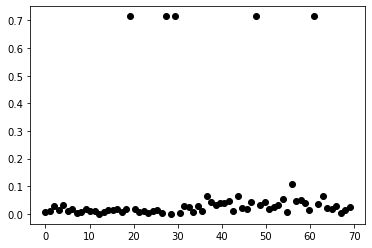

In [67]:
%matplotlib inline

x = np.linspace(0, 69, 69)
y = val_signals[100020]

plt.plot(x, y, 'o', color='black');